# Step 1: Data Wrangling

This notebook is the first step in my wildfire prediction project. In this notebook I:
* Extract CA wildfires 2005-2015 from the national database
* Convert Julian dates to standard format
* Leverage latitude/longtitude columns to create a GeoDataFrame object for spatial processing
* Extract a series of spatiotemporal variables from various climate datasets leveraging Google Earth Engine via earthengine-api. Some variables are extracted for the day the widlfire was discovered, other are averaged over the preceding week.
* Join vegetation type and ecoregion features based on location
* Fill in missing data in County column via location
* Validate/confirm all joins

In [2]:
#package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from sqlalchemy import create_engine
import ee
import geemap
from ipyleaflet import Map, basemaps, basemap_to_tiles
import rasterio

/Users/allankapoor/Documents/Springboard/wildfire_project/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#%reload_ext autoreload

## Loading and processing wildfire data

Source: https://www.kaggle.com/rtatman/188-million-us-wildfires

From the original SQLite database, extract records for California, 2005 and later. Convert date a standard YYY-MM-DD format which can be read by GEE.

In [2]:
#initializing SQL engine
engine = create_engine('sqlite:////Users/allankapoor/Documents/Springboard/wildfire_project/Datasets/FPA_FOD_20170508.sqlite')
#engine.table_names()
#extracting subset of dataset (California, 2005 and on) to pandas dataframe
wildfires = pd.read_sql_query("SELECT * FROM Fires WHERE FIRE_YEAR >= 2005 AND STATE ='CA' ", engine)

In [3]:
#inspect table
wildfires.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,8,8,FS-1418854,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,B,40.968056,-122.433889,13.0,STATE OR PRIVATE,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00t)\xe8\xd5\xc4\x9b^\...
2,9,9,FS-1418856,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,B,41.233611,-122.283333,13.0,STATE OR PRIVATE,CA,None,None,None,"b'\x00\x01\xad\x10\x00\x00\xdc\x8d\x1e""""\x92^\..."
3,77,78,FS-1419054,FED,FS-FIRESTAT,FS,USCASRF,Six Rivers National Forest,0510,Six Rivers National Forest,...,A,41.037222,-123.533056,5.0,USFS,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\xa8I\x11\x95\x1d\xe...
4,88,89,FS-1419071,FED,FS-FIRESTAT,FS,USCAANF,Angeles National Forest,0501,Angeles National Forest,...,A,34.174444,-117.765000,5.0,USFS,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00(\\\x8f\xc2\xf5p]\xc...


In [5]:
#inspecting different date related columns
wildfires[['FIRE_YEAR','DISCOVERY_DOY','DISCOVERY_DATE']]

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_DATE
0,2005,33,2453403.5
1,2005,67,2453437.5
2,2005,74,2453444.5
3,2005,178,2453548.5
4,2005,114,2453484.5
...,...,...,...
83907,2015,269,2457291.5
83908,2015,278,2457300.5
83909,2015,122,2457144.5
83910,2015,287,2457309.5


In [6]:
#calculate epoch for Julian dates
epoch = pd.to_datetime(0, unit='s').to_julian_date()

#convert Julian dates to timestamps
wildfires['DISCOVERY_DT'] = pd.to_datetime(wildfires['DISCOVERY_DATE'] - epoch, unit='D')

#drop shape field which is unnecessary
wildfires = wildfires.drop(['Shape'], axis='columns')

#create column with dates as strings (Google Earth Engine cannot ingest timestamps)
wildfires['DISCOVERY_DT_STR'] = wildfires['DISCOVERY_DT'].dt.strftime('%Y-%m-%d')

In [7]:
#checking dates are formatted correctly
wildfires['DISCOVERY_DT_STR']

0        2005-02-02
1        2005-03-08
2        2005-03-15
3        2005-06-27
4        2005-04-24
            ...    
83907    2015-09-26
83908    2015-10-05
83909    2015-05-02
83910    2015-10-14
83911    2015-03-14
Name: DISCOVERY_DT_STR, Length: 83912, dtype: object

In [8]:
wildfires = wildfires.drop(['DISCOVERY_DT_STR'], axis='columns')

In [9]:
#convert dataframe to geodataframe via lat.long columns. Per documentation, coordinate system is NAD83 (EPSG:4269)
wildfires_gdf = gpd.GeoDataFrame(wildfires, geometry=gpd.points_from_xy(wildfires.LONGITUDE, wildfires.LATITUDE), crs='EPSG:4269')
wildfires_gdf.index.name = 'index'

<AxesSubplot:>

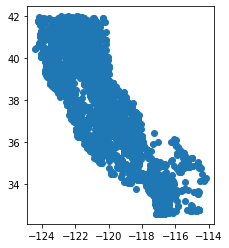

In [10]:
#confirm gpd plots correctly
wildfires_gdf[wildfires_gdf['FIRE_YEAR']==2005].plot()

## Google Earth Engine Setup

Export wildfires table to csv for upload to GEE and then load it as a Feature Collection. This will allow for sampling of various variables based on wildfire dat/location via Google Earth Engine

In [2]:
#geemap.update_package()
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWiG64vZ1GiQZ-dMsp3yWL2ibj6K8jLmjv31KQJ0nPTYfeN9g632cS4

Successfully saved authorization token.


In [12]:
#export wildfires_gdf as CSV for upload to Google Earth Engine
wildfires_gdf.to_csv(r"Datasets/wildfires.csv")

In [25]:
#load wildfire points feature collection from Google Earth Engine
WF_pts = ee.FeatureCollection('users/allanbkapoor/wildfires3')

## TOPOGRAPHY VARIABLES

Topography variables from the National Elevataion Dataset developed by USGS, available on Google Earth Engine. Here I use GEE to calculate elevation, slope, and aspect (the direction a slope faces) for the location of each wildfire. The functions are designed to run on GEE servers and the outputs are exported as CSVs to Google Drive. I then download these files and load then as pandas dataframes to be joined to the main wildfire dataframe.

Source: https://developers.google.com/earth-engine/datasets/catalog/USGS_NED

In [26]:
#load DEM image
DEM_img = ee.Image('USGS/NED')

#extract individual band 'elevation' (units are meters)
DEM = DEM_img.select('elevation')

#calculate slope from DEM (units are degrees)
slope = ee.Terrain.slope(DEM)
slope = slope.rename('slope')

#calculate aspect from DEM (units are degrees)
aspect = ee.Terrain.aspect(DEM)
aspect = aspect.rename('aspect')

#sample points from DEM, slope, aspect
WFpts_elevation = DEM.sampleRegions(collection=WF_pts, scale=30, geometries=True)
WFpts_slope = slope.sampleRegions(collection=WF_pts, scale=30, geometries=True)
WFpts_aspect = aspect.sampleRegions(collection=WF_pts, scale=30, geometries=True)

In [27]:
#export output tables to Google Drive
task_elev = ee.batch.Export.table.toDrive(collection=WFpts_elevation, description='NED_elevation', fileFormat='CSV', folder='GEE Outputs')
task_elev.start()

task_slope = ee.batch.Export.table.toDrive(collection=WFpts_slope, description='NED_slope', fileFormat='CSV', folder='GEE Outputs')
task_slope.start()

task_aspect = ee.batch.Export.table.toDrive(collection=WFpts_aspect, description='NED_aspect', fileFormat='CSV', folder='GEE Outputs')
task_aspect.start()

#run to check status of export
#task.status()

Define function that joins a table outputted from GEE to the wildfires dataframe

In [11]:
#function for joining tables from GEE to main wildfires table
def join_gee_data(orig_df,gee_df,fieldname):
    '''
    takes as input a csv file (from GEE) and joins the new field from it to the existing pandas dataframe
    '''
    
    #isolate OBJECTID and field to be joined
    join_df = gee_df[['OBJECTID',fieldname]]
    
    #join to origi_df
    joined_df = pd.merge(orig_df,join_df,on='OBJECTID')
    
    #return the joined dataframe
    return joined_df

After export tasks are complete, manually download output tables from Google Drive and save to project folder

In [12]:
#load DEM tables from GEE into dataframes
gee_elev = pd.read_csv('Datasets/NED_elevation.csv', low_memory=False)
gee_slope = pd.read_csv('Datasets/NED_slope.csv', low_memory=False)
gee_aspect = pd.read_csv('Datasets/NED_aspect.csv', low_memory=False)

#join df to main wildfire df
wildfires_gdf = join_gee_data(wildfires_gdf,gee_elev,'elevation')
wildfires_gdf = join_gee_data(wildfires_gdf,gee_slope,'slope')
wildfires_gdf = join_gee_data(wildfires_gdf,gee_aspect,'aspect')

In [13]:
#confirm GEE columns have joined
wildfires_gdf.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'DISCOVERY_DT', 'geometry', 'elevation',
       'slope', 'aspect'],
      dtype='object')

In [14]:
#sense checking elevation results
wildfires_gdf['elevation'].describe()

count    83912.000000
mean       607.364248
std        641.395737
min        -83.107810
25%         99.182772
50%        387.417215
75%        912.970300
max       3795.679200
Name: elevation, dtype: float64

In [15]:
#filtering for fires that are below sea level
below_SL = wildfires_gdf[wildfires_gdf['elevation']<0]
below_SL.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,DISCOVERY_DT,geometry,elevation,slope,aspect
1350,9597,9642,FS-1436805,FED,FS-FIRESTAT,FS,USCACNF,Cleveland National Forest,0502,Cleveland National Forest,...,MISSING/NOT SPECIFIED,CA,73,073,San Diego,2006-06-05,POINT (-116.86944 36.27806),-83.107810,0.048313,107.266320
8794,283824,289253,W-514611,FED,DOI-WFMI,BIA,USCASCA,Southern California Agency,CASCA,Southern California Agency,...,BIA,CA,None,None,None,2005-04-04,POINT (-116.15560 33.56890),-46.131970,1.944300,41.795036
8797,283827,289256,W-514783,FED,DOI-WFMI,BIA,USCASCA,Southern California Agency,CASCA,Southern California Agency,...,BIA,CA,None,None,None,2005-05-07,POINT (-116.14000 33.56340),-51.172462,0.255867,66.258170
11368,315769,322263,W-568571,FED,DOI-WFMI,BLM,USCACDD,California Desert District,CACDD,California Desert District,...,PRIVATE,CA,Riverside,065,Riverside,2005-01-02,POINT (-116.25940 33.62009),-7.147705,0.409029,51.927708
11371,315772,322266,W-568573,FED,DOI-WFMI,BLM,USCACDD,California Desert District,CACDD,California Desert District,...,PRIVATE,CA,Riverside,065,Riverside,2005-02-01,POINT (-116.19009 33.56184),-10.858791,1.075268,354.632720


In [16]:
#confirming by spot checking a few coordinates in Google Earth that they are really below sea level
below_SL.loc[:,['LATITUDE','LONGITUDE','elevation']]

,LATITUDE,LONGITUDE,elevation
1350,36.278056,-116.869444,-83.107810
8794,33.568900,-116.155600,-46.131970
8797,33.563400,-116.140000,-51.172462
11368,33.620089,-116.259400,-7.147705
11371,33.561839,-116.190089,-10.858791
...,...,...,...
75659,33.631865,-116.181193,-32.115670
75685,33.598583,-116.095069,-49.206730
75745,33.709175,-116.179773,-11.408268
76350,33.598299,-116.198516,-35.072914


In [17]:
#confirming slope values seem reasonable (cannot be >90)
wildfires_gdf['slope'].describe()

count    83912.000000
mean         7.236422
std          8.670195
min          0.000000
25%          0.976436
50%          3.637877
75%         10.506136
max         73.758484
Name: slope, dtype: float64

In [18]:
#confirming aspect values seem reasonable (cannot be >360)
wildfires_gdf['aspect'].describe()

count    83912.000000
mean       179.687199
std        100.257313
min         -0.000000
25%         93.731689
50%        186.687270
75%        261.237900
max        359.999150
Name: aspect, dtype: float64

## WEATHER VARIABLES

Weather variables are available as multiband timeseries raster grids from Google Earth Engine. Here I extract various weather variables based on the location and date of each wildfire. The data source and time period is different for each variable. First I define functions that extract pixel values based on an input dataset, band, and time delta. The functions are designed to run on GEE servers and the outputs are exported as CSVs to Google Drive. I then download these files and load then as pandas dataframes to be joined to the main wildfire dataframe.

### Define GEE functions
Two versions of the function, one that averages over past days and one that averages over future days. They cannot be combined because GEE server-side functions cannot include Python (client-side) conditional logic.

In [21]:
#This version is for getting a mean across a negative time delta
def get_pixel_date_values_neg(image_set, band_name, day_delta, output_column):
    '''
    For the specified band (band_name) of a specificed dataset (image_set) calculates the MEAN over specified time period
    (day_delta) and extracts pixel values at point locations in wildfires feature class to output_column 
    '''
    # load wildfire points/dates feature collection from Google Earth Engine assets
    WF_pts = ee.FeatureCollection('users/allanbkapoor/wildfires3')

    # get image collection
    IC = ee.ImageCollection(image_set)

    # select desired band
    single_band = IC.select(band_name)

    def get_single_date_value(feat):
        '''
        gets pixels value for a single feature based on long/lat and date
        '''

        #get data for that feature from date column
        date1 = ee.Date(feat.get('DISCOVERY_DT'))
        date2 = date1.advance(day_delta, 'day')
        
        projection_obj = ee.Projection('EPSG:4326')
        point = feat.get('geometry')
        scale = 4000

        #mean of images based on date range
        single_image = single_band.filterBounds(point).filterDate(date2,date1).mean()

        point_value_fc = single_image.sample(point, scale, projection=projection_obj, dropNulls=False)
        point_value = point_value_fc.first().get(band_name)

        return feat.set({output_column: point_value})

    #map the function over the feature collection
    WF_pts_values = WF_pts.map(get_single_date_value)
    
    #return the output fc
    return WF_pts_values

In [23]:
#This version is for getting a mean across a positive time delta
def get_pixel_date_values_pos(image_set, band_name, day_delta, output_column):
    '''
    For the specified band (band_name) of a specificed dataset (image_set) calculates the MEAN over specified time period
    (day_delta) and extracts pixel values at point locations in wildfires feature class to output_column 
    '''
    # load wildfire points/dates feature collection from Google Earth Engine assets
    WF_pts = ee.FeatureCollection('users/allanbkapoor/wildfires3')

    # get image collection
    IC = ee.ImageCollection(image_set)

    # select desired band
    single_band = IC.select(band_name)

    def get_single_date_value(feat):
        '''
        gets pixels value for a single feature based on long/lat and date
        '''

        #get data for that feature from date column
        date1 = ee.Date(feat.get('DISCOVERY_DT'))
        date2 = date1.advance(day_delta, 'day')
        
        projection_obj = ee.Projection('EPSG:4326')
        point = feat.get('geometry')
        scale = 4000

        #mean of images based on date range
        single_image = single_band.filterBounds(point).filterDate(date1,date2).mean()

        point_value_fc = single_image.sample(point, scale, projection=projection_obj, dropNulls=False)
        point_value = point_value_fc.first().get(band_name)

        return feat.set({output_column: point_value})

    #map the function over the feature collection
    WF_pts_values = WF_pts.map(get_single_date_value)
    
    #return the output fc
    return WF_pts_values

### Temperature

Average daily maximum temperature for the week preceding each wildfire.

Source: https://developers.google.com/earth-engine/datasets/catalog/OREGONSTATE_PRISM_AN81d?hl=en#citations

Daly, C., J.I. Smith, and K.V. Olson. 2015. Mapping atmospheric moisture climatologies across the conterminous United States. PloS ONE 10(10):e0141140. doi:10.1371/journal.pone.0141140.

In [78]:
# extract pixel values for the mean of the max temperature band, for the preceding 7 days from PRISM daily
WF_pts_tmax = get_pixel_date_values_neg('OREGONSTATE/PRISM/AN81d','tmax', -7, 'max_temp')

In [79]:
# run task on GEE servers and export to Google Drive
task_tmax = ee.batch.Export.table.toDrive(collection=WF_pts_tmax, description='mean tmax, prior 7 days', fileNamePrefix = 'PRISM_tmax_1', fileFormat='CSV', folder='GEE Outputs')
task_tmax.start()

### Dew Point

Average daily dew point for the week preceding each wildfire.

Source: https://developers.google.com/earth-engine/datasets/catalog/OREGONSTATE_PRISM_AN81d?hl=en#citations

Daly, C., J.I. Smith, and K.V. Olson. 2015. Mapping atmospheric moisture climatologies across the conterminous United States. PloS ONE 10(10):e0141140. doi:10.1371/journal.pone.0141140.

In [80]:
# extract pixel values for mean of the dew point band, for the preceding 7 days, from PRISM daily
WF_pts_tdmean = get_pixel_date_values_neg('OREGONSTATE/PRISM/AN81d','tdmean', -7, 'dew_point')

In [81]:
# run task on GEE servers and export to Google Drive
task_tdmean = ee.batch.Export.table.toDrive(collection=WF_pts_tdmean, description='mean tdmean, prior 7 days', fileNamePrefix = 'PRISM_tdmean_1', fileFormat='CSV', folder='GEE Outputs')
task_tdmean.start()

Task runs on GEE servers and will output a CSV file to Google Drive

### Precipitation

Average monthly precipitation for the year preceding each wildfire. I chose to sample this variable over a much longer time period because the summer months in California are quite dry so the most recent rain may have been months before each wildfire. As the precipitation variable also includes snowfall, this is also getting at how much snow fell in that area during the year prior to the wildfire.

Source: https://developers.google.com/earth-engine/datasets/catalog/OREGONSTATE_PRISM_AN81m

Daly, C., J.I. Smith, and K.V. Olson. 2015. Mapping atmospheric moisture climatologies across the conterminous United States. PloS ONE 10(10):e0141140. doi:10.1371/journal.pone.0141140.

In [82]:
# extract pixel values for mean of the precipitation band, for the preceding year (365 days), from PRISM monthly
WF_pts_ppt = get_pixel_date_values_neg('OREGONSTATE/PRISM/AN81m','ppt', -365, 'mean_monthly_ppt')

In [83]:
# run task on GEE servers and export to Google Drive
task_ppt = ee.batch.Export.table.toDrive(collection=WF_pts_ppt, description='mean monthly ppt, prior year', fileNamePrefix = 'PRISM_ppt_1', fileFormat='CSV', folder='GEE Outputs')
task_ppt.start()

Task runs on GEE servers and will output a CSV file to Google Drive

### Wind Speed

Average windspeed over the day following the start of the wildfire. Wind speed comes from the GRIDMET daily timeseries dataset. To get wind conditions at the location and time each wildfire started, I take the mean of that day and the following day for each wildfire.

Source: https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET?hl=en

Abatzoglou J. T., Development of gridded surface meteorological data for ecological applications and modelling, International Journal of Climatology. (2012) doi:10.1002/joc.3413

In [84]:
# extract pixel values for wind speed band, for a single day
WF_pts_vs = get_pixel_date_values_pos('IDAHO_EPSCOR/GRIDMET','vs', 1, 'wind_speed')

In [85]:
# run task on GEE servers and export to Google Drive
task_vs = ee.batch.Export.table.toDrive(collection=WF_pts_vs, description='windspeed, mean of day and next', fileNamePrefix = 'GRIDMET_vs_1', fileFormat='CSV', folder='GEE Outputs')
task_vs.start()

Task runs on GEE servers and will output a CSV file to Google Drive

### Additional GRIDMET Variables

GRIDMET has some additional derived bands that relate specifically to wildfire risk. The variables are:
* erc: NFDRS fire danger index Energy release component
* bi: NFDRS fire danger index	Burning index
* fm100: 100-hour dead fuel moisture
* fm100: 1000-hour dead fuel moisture

In [24]:
# extract pixel values for wind speed band, for a single day (these are all derived based on prior days so a single day is sufficient)
WF_pts_erc = get_pixel_date_values_pos('IDAHO_EPSCOR/GRIDMET','erc', 1, 'erc')
WF_pts_bi = get_pixel_date_values_pos('IDAHO_EPSCOR/GRIDMET','bi', 1, 'bi')
WF_pts_fm100 = get_pixel_date_values_pos('IDAHO_EPSCOR/GRIDMET','fm100', 1, 'fm100')
WF_pts_fm1000 = get_pixel_date_values_pos('IDAHO_EPSCOR/GRIDMET','fm1000', 1, 'fm1000')

# run task on GEE servers and export to Google Drive
task_erc = ee.batch.Export.table.toDrive(collection=WF_pts_erc, description='energy release component, mean of day and next', fileNamePrefix = 'GRIDMET_erc', fileFormat='CSV', folder='GEE Outputs')
task_erc.start()

task_bi = ee.batch.Export.table.toDrive(collection=WF_pts_bi, description='burn index, mean of day and next', fileNamePrefix = 'GRIDMET_bi', fileFormat='CSV', folder='GEE Outputs')
task_bi.start()

task_fm100 = ee.batch.Export.table.toDrive(collection=WF_pts_fm100, description='100-hour dead fuel moisture, mean of day and next', fileNamePrefix = 'GRIDMET_fm100', fileFormat='CSV', folder='GEE Outputs')
task_fm100.start()

task_fm1000 = ee.batch.Export.table.toDrive(collection=WF_pts_fm1000, description='1000-hour dead fuel moisture, mean of day and next', fileNamePrefix = 'GRIDMET_fm1000', fileFormat='CSV', folder='GEE Outputs')
task_fm1000.start()

### Spot checking weather variable results
Spot checking results for individual points, by hard entering location/date parameters, and by pulling location/date parameters from the wildfire feature class.

In [86]:
# get image collection
IC = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET')

# select desired band
single_band = IC.select('vs')

In [87]:
%%time
# Spot check using hard coded parameters
date_test = ee.Date('2011-03-04')
date_test2 = ee.Date('2011-03-05')
coordinates = [-118.55889094609277, 34.56777630000734]
projection_obj = ee.Projection('EPSG:4326')
point_test = ee.Geometry.Point(coordinates, proj=projection_obj)
single_image = single_band.filterBounds(point_test).filterDate(date_test,date_test2).mean()
scale_test = 4000
#point_value_test = windImage_test.sample(point_test, scale_test, projection=projection_obj) #.first().get('vs').getInfo()
point_value_test = single_image.sample(point_test, scale=scale_test, projection=projection_obj)
point_value = point_value_test.first().get("vs")

point_value.getInfo()

CPU times: user 7.79 ms, sys: 1.52 ms, total: 9.32 ms
Wall time: 166 ms


4.09441614151001

In [88]:
%%time
# Spot check using parameters from first feature in wildfire feature class
date_test = ee.Date(WF_pts.first().get('DISCOVERY_DT'))
date_test2 = date_test.advance(1, 'day')
projection_obj = ee.Projection('EPSG:4326')
point_test = WF_pts.first().get('geometry')
single_image = single_band.filterBounds(point_test).filterDate(date_test,date_test2).mean()
scale_test = 4000
#point_value_test = windImage_test.sample(point_test, scale_test, projection=projection_obj) #.first().get('vs').getInfo()
point_value_test = single_image.sample(point_test, scale=scale_test, projection=projection_obj)
point_value = point_value_test.first().get("vs")

#define point for spot checking
point_geometry = ee.Geometry.Point([-118.55889094609277, 34.56777630000734], proj=projection_obj)

point_value.getInfo()

CPU times: user 8.68 ms, sys: 1.82 ms, total: 10.5 ms
Wall time: 465 ms


4.09441614151001

In [90]:
WF_pts.filter("system:index == '0000000000000001026b'").first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-118.67055575467313, 34.55250387801756]},
 'id': '0000000000000001026b',
 'properties': {'COMPLEX_NAME': '',
  'CONT_DATE': 2456899.5,
  'CONT_DOY': 242,
  'CONT_TIME': '1235',
  'COUNTY': 'Los Angeles',
  'DISCOVERY_DATE': 2456899.5,
  'DISCOVERY_DOY': 242,
  'DISCOVERY_DT': '2014-08-30',
  'DISCOVERY_TIME': '1210',
  'FIPS_CODE': '037',
  'FIPS_NAME': 'Los Angeles',
  'FIRE_CODE': 'EK1S',
  'FIRE_NAME': 'CAMRY',
  'FIRE_SIZE': 0.10000000149011612,
  'FIRE_SIZE_CLASS': 'A',
  'FIRE_YEAR': 2014,
  'FOD_ID': 300000783,
  'FPA_ID': 'FS-1524784',
  'ICS_209_INCIDENT_NUMBER': '',
  'ICS_209_NAME': '',
  'LOCAL_FIRE_REPORT_ID': '108',
  'LOCAL_INCIDENT_ID': '65',
  'MTBS_FIRE_NAME': '',
  'MTBS_ID': '',
  'NWCG_REPORTING_AGENCY': 'FS',
  'NWCG_REPORTING_UNIT_ID': 'USCAANF',
  'NWCG_REPORTING_UNIT_NAME': 'Angeles National Forest',
  'OBJECTID': 1722704,
  'OWNER_CODE': 5,
  'OWNER_DESCR': 'USFS',
  'SOURCE_REPORTING_UNIT': 

In [91]:
%%time
# Spot check by running full function and then pulling result for first feature
WF_pts_wind_test = get_pixel_date_values_pos('IDAHO_EPSCOR/GRIDMET','vs', 1, 'wind_speed')
WF_pts_wind_test.first().getInfo()

CPU times: user 10.2 ms, sys: 1.51 ms, total: 11.7 ms
Wall time: 1.29 s


{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-118.55889094609277, 34.567776299125434]},
 'id': '00000000000000009ea6',
 'properties': {'COMPLEX_NAME': '',
  'CONT_DATE': 2455624.5,
  'CONT_DOY': 63,
  'CONT_TIME': '1500',
  'COUNTY': '',
  'DISCOVERY_DATE': 2455624.5,
  'DISCOVERY_DOY': 63,
  'DISCOVERY_DT': '2011-03-04',
  'DISCOVERY_TIME': '1034',
  'FIPS_CODE': '',
  'FIPS_NAME': '',
  'FIRE_CODE': 'F01S',
  'FIRE_NAME': 'DRY',
  'FIRE_SIZE': 0.5,
  'FIRE_SIZE_CLASS': 'B',
  'FIRE_YEAR': 2011,
  'FOD_ID': 20023357,
  'FPA_ID': 'FS-1493682',
  'ICS_209_INCIDENT_NUMBER': '',
  'ICS_209_NAME': '',
  'LOCAL_FIRE_REPORT_ID': '12',
  'LOCAL_INCIDENT_ID': '9',
  'MTBS_FIRE_NAME': '',
  'MTBS_ID': '',
  'NWCG_REPORTING_AGENCY': 'FS',
  'NWCG_REPORTING_UNIT_ID': 'USCAANF',
  'NWCG_REPORTING_UNIT_NAME': 'Angeles National Forest',
  'OBJECTID': 1457145,
  'OWNER_CODE': 5,
  'OWNER_DESCR': 'USFS',
  'SOURCE_REPORTING_UNIT': '0501',
  'SOURCE_REPORTING_UNIT_NAME': 'Angele

In [3]:
# create map object for spot checking the above values
Map = geemap.Map()

# add items to map for spot checking
#wind_vis = {'min':0, 'max':30, 'palette':['3399FF', 'FF3333']}
#Map.addLayer(single_image, wind_vis, 'Wind speed for fire date')
#Map.addLayer(point_geometry, {}, 'Fire Location')

# display map widget
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

I used the interactive map widget above to spot check the pixel value. The map displays a single point, which is the first wildfire in the dataset. The raster image is the windspeed the day that fire occured. Using the Inspector tool available in the tool panel, we can see that the pixel value (4.09441614151001) matches the output of the tests above.

## Load and join weather variables

After server-side processing tasks are complete, download the results from Google Drive and save them to the project folder. Load the CSVs as dataframes and then run the previously defined join function to join the desired fields to the main wildfires dataframe.

In [19]:
#load tables from GEE into dataframes
gee_temp = pd.read_csv('Datasets/PRISM_tmax_1.csv', low_memory=False)
gee_precip = pd.read_csv('Datasets/PRISM_ppt_1.csv', low_memory=False)
gee_dewpoint = pd.read_csv('Datasets/PRISM_tdmean_1.csv', low_memory=False)
gee_windspeed = pd.read_csv('Datasets/GRIDMET_vs_1.csv', low_memory=False) 

gee_erc = pd.read_csv('Datasets/GRIDMET_erc.csv', low_memory=False)
gee_bi = pd.read_csv('Datasets/GRIDMET_bi.csv', low_memory=False)
gee_fm100 = pd.read_csv('Datasets/GRIDMET_fm100.csv', low_memory=False)
gee_fm1000 = pd.read_csv('Datasets/GRIDMET_fm1000.csv', low_memory=False) 

In [20]:
wildfires_gdf.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'DISCOVERY_DT', 'geometry', 'elevation',
       'slope', 'aspect'],
      dtype='object')

In [21]:
#join df to main wildfire gdf
wildfires_gdf = join_gee_data(wildfires_gdf,gee_precip,'mean_monthly_ppt')
wildfires_gdf = join_gee_data(wildfires_gdf,gee_dewpoint,'dew_point')
wildfires_gdf = join_gee_data(wildfires_gdf,gee_temp,'max_temp')
wildfires_gdf = join_gee_data(wildfires_gdf,gee_windspeed,'wind_speed')

wildfires_gdf = join_gee_data(wildfires_gdf,gee_erc,'erc')
wildfires_gdf = join_gee_data(wildfires_gdf,gee_bi,'bi')
wildfires_gdf = join_gee_data(wildfires_gdf,gee_fm100,'fm100')
wildfires_gdf = join_gee_data(wildfires_gdf,gee_fm1000,'fm1000')

In [22]:
wildfires_gdf.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'DISCOVERY_DT', 'geometry', 'elevation',
       'slope', 'aspect', 'mean_monthly_ppt', 'dew_point', 'max_temp',
       'wind_speed', 'erc', 'bi', 'fm100', 'fm1000'],
      dtype='object')

In [23]:
# confirm join based on OBJECTID is working properly. The geodataframe row with the same OBJECTID should have the same windspeed value (4.09) and other fields as the fteaur printed above.
wildfires_gdf[wildfires_gdf['OBJECTID']==1457145]

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,bi,fm100,fm1000
40614,1457145,20023357,FS-1493682,FED,FS-FIRESTAT,FS,USCAANF,Angeles National Forest,0501,Angeles National Forest,...,27.016422,306.96698,65.380585,-0.522429,11.439,4.094416,36.788322,34.722488,13.512623,16.428337


## VEGETATION TYPE

Vegetation type data is available as a pixel grid with values ('VEG_CODE') that correspond to a lookup table. Here I use geopandas and rasterio to sample the pixel value of each wildfire location. Then I load the lookup table and join all fields from the lookup table to the wildfire table based on the VEG_CODE value. The result is a series of fields with information about the type of vegetation at each wildfire location.

Source: https://map.dfg.ca.gov/metadata/ds1327.html

In [24]:
#set up coordinates for sampling
wf_pts = wildfires_gdf.loc[:,['LONGITUDE', 'LATITUDE', 'OBJECTID', 'geometry']]
wf_pts.index = range(len(wf_pts))
coords = [(x,y) for x, y in zip(wf_pts.LONGITUDE, wf_pts.LATITUDE)]

# open vegetation raster dataset (converted to NAD83 in QGIS)
veg_raster = rasterio.open(r'Datasets/FVEG_proj/FVEG_NAD83.tif')

# Sample the vegetation code at every point location and store values in DataFrame
wf_pts['VEG_CODE'] = [x for x in veg_raster.sample(coords)]
wf_pts['VEG_CODE'] = wf_pts.apply(lambda x: x['VEG_CODE'][0], axis=1)

# load lookup table for vegetation codes
fveg_table = pd.read_csv(r"Datasets/fveg15_11_TABLE.csv")
fveg_table = fveg_table.rename(columns = {'Value':'VEG_CODE'})
fveg_table.head()

# join vegetation table to wf_pts
wf_pts_joined = pd.merge(wf_pts, fveg_table, on='VEG_CODE', how='left')

In [25]:
#subset of vegetation columns to be joined
desired_columns = ['OBJECTID','VEG_CODE', 'WHRALL', 'LIFE_FORM', 'WHRNUM', 'WHRNAME',
                   'WHRTYPE', 'WHRSIZE', 'WHRDENSITY', 'WHR10NUM', 'WHR10NAME',
                   'WHR13NUM', 'WHR13NAME']

#join to main wildfires gdf based on OBJECTID
wildfires_gdf = pd.merge(wildfires_gdf, wf_pts_joined[desired_columns], on='OBJECTID', how='left')

## USDA / Forest Service Probablistic Wildfire Components

The U.S. Forest Service Missoula Fire Sciences Laboratory generated a series of raster datasets representing burn probability (BP) and conditional fire intensity level (FIL, also referred to as flame length) for the conterminous U.S. through its geospatial Fire Simulation (FSim) system. FSim estimated the probabilistic components of wildfire risk for 128 distinct regions of contemporary wildfire activity, simulating the occurrence and growth of large and fast-moving wildfires under tens for thousands of hypothetical contemporary fire seasons.

The burn probability raster dataset models the probability of an area being burned by a large fire (i.e., a fire that escapes initial fire suppression and spreads) at a 270-meter grid spatial resolution. The cell value in the raster file contains the mean annual burn probability as a value between 0 and 1 and represents the tendency for the cell area to burn due to a large fire on an annual basis given its landscape, contemporary weather conditions, and probability of containment.

The fire intensity level dataset consists of six raster files, each representing the portion of all simulated fires that burned in the cell area at the specified flame length: FIL1 = < 2 feet (ft); FIL2 = 2 < 4 ft.; FIL3 = 4 < 6 ft.; FIL4 = 6 < 8 ft.; FIL5 = 8 < 12 ft.; and FIL6 = 12+ ft. These files are also at a 270-meter grid spatial resolution.

In [27]:
#set up coordinates for sampling
wf_pts = wildfires_gdf.loc[:,['LONGITUDE', 'LATITUDE', 'OBJECTID', 'geometry', 'FIRE_SIZE_CLASS']]
wf_pts.index = range(len(wf_pts))
coords = [(x,y) for x, y in zip(wf_pts.LONGITUDE, wf_pts.LATITUDE)]

# open raster datasets (converted to NAD83 in ArcGIS)
raster_bp = rasterio.open(r'Datasets/USDA_FS_WF/bp.tif')
raster_fi1 = rasterio.open(r'/Datasets/USDA_FS_WF/fi1.tif')
raster_fi2 = rasterio.open(r'/Datasets/USDA_FS_WF/fi2.tif')
raster_fi3 = rasterio.open(r'/Datasets/USDA_FS_WF/fi3.tif')
raster_fi4 = rasterio.open(r'/Datasets/USDA_FS_WF/fi4.tif')
raster_fi5 = rasterio.open(r'/Datasets/USDA_FS_WF/fi5.tif')
raster_fi6 = rasterio.open(r'/Datasets/USDA_FS_WF/fi6.tif')

In [28]:
# Sample the vegetation code at every point location and store values in DataFrame
wf_pts['usda_bp'] = [x[0] for x in raster_bp.sample(coords)]
wf_pts['usda_fi1'] = [x[0] for x in raster_fi1.sample(coords)]
wf_pts['usda_fi2'] = [x[0] for x in raster_fi2.sample(coords)]
wf_pts['usda_fi3'] = [x[0] for x in raster_fi3.sample(coords)]
wf_pts['usda_fi4'] = [x[0] for x in raster_fi4.sample(coords)]
wf_pts['usda_fi5'] = [x[0] for x in raster_fi5.sample(coords)]
wf_pts['usda_fi6'] = [x[0] for x in raster_fi6.sample(coords)]

<AxesSubplot:>

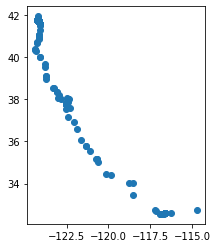

In [29]:
#confirming that wildfires getting values below 0 are outside the raster grid area
wf_pts[wf_pts['usda_bp'] <0].plot()

In [30]:
#confirming we aren't loosing any/many large wildfires if we drop these columns
wf_pts[wf_pts['usda_bp'] <0].value_counts('FIRE_SIZE_CLASS')

FIRE_SIZE_CLASS
A    158
B     49
C      1
E      1
F      1
dtype: int64

In [31]:
#subset of columns to be joined
desired_columns = ['OBJECTID','usda_bp', 'usda_fi1', 'usda_fi2', 'usda_fi3', 'usda_fi4', 'usda_fi5', 'usda_fi6']

#join to main wildfires gdf based on OBJECTID
wildfires_gdf = pd.merge(wildfires_gdf, wf_pts[desired_columns], on='OBJECTID', how='left')

In [32]:
wildfires_gdf.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,WHR10NAME,WHR13NUM,WHR13NAME,usda_bp,usda_fi1,usda_fi2,usda_fi3,usda_fi4,usda_fi5,usda_fi6
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,Conifer,31.0,Conifer Forest,0.007337,0.09375,0.750,0.156250,0.000000,0.000000,0.000000
1,8,8,FS-1418854,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,Water,90.0,Water,0.003938,0.00000,0.000,0.020833,0.291667,0.458333,0.229167
2,9,9,FS-1418856,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,Conifer,31.0,Conifer Forest,0.008459,0.00000,0.000,0.012048,0.000000,0.277108,0.710843
3,77,78,FS-1419054,FED,FS-FIRESTAT,FS,USCASRF,Six Rivers National Forest,0510,Six Rivers National Forest,...,Conifer,31.0,Conifer Forest,0.014065,0.00000,0.000,0.049296,0.338028,0.394366,0.218310
4,88,89,FS-1419071,FED,FS-FIRESTAT,FS,USCAANF,Angeles National Forest,0501,Angeles National Forest,...,Shrub,70.0,Shrub,0.040275,0.11250,0.785,0.102500,0.000000,0.000000,0.000000


# EPA ECOREGIONS

As the vegetation types are quite granular, it may be useful to also have a more general indicator of what ecological region each fire occured in. For this, I used EPA Level III Ecoregions. Level III was selected because it is granular enough for there to be several different zones in California, but not so granular that the ecoregions might become redudant with vegetation type.

Ecoregions are available in shapefile format from the US EPA. I used geopandas to join ecoregion attributes to the wildfire points based on location.

Source: https://www.epa.gov/eco-research/level-iii-and-iv-ecoregions-continental-united-states

In [33]:
#load ecoregions shapefile as geodataframe
ecoregions_gdf = gpd.read_file('Datasets/us_eco_l3/us_eco_l3.shp')

#check coordinate system of both gdfs (needs to be the same for spatial join to work properly)
ecoregions_crs = ecoregions_gdf.crs
wildfires_crs = wildfires_gdf.crs

print(f'CRS of ecoregions: {ecoregions_crs}')
print(f'CRS of wildfires: {wildfires_crs}')

CRS of ecoregions: PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102039"]]
CRS of wildfires: EPSG:4269


In [34]:
# convert CRS of ecoregions to NAD83 
ecoregions_gdf = ecoregions_gdf.to_crs(4269)

In [35]:
# confirm geodataframes are now in same crs
ecoregions_gdf.crs == wildfires_gdf.crs

True

<AxesSubplot:>

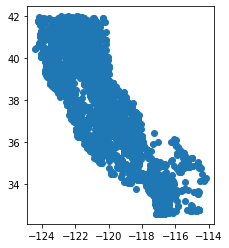

In [36]:
# plot wildfires to confirm
wildfires_gdf[wildfires_gdf['FIRE_YEAR']==2005].plot()

<AxesSubplot:>

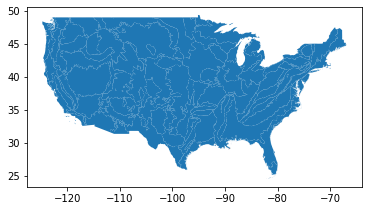

In [37]:
# plot ecoregions to confirm
ecoregions_gdf.plot()

In [38]:
ecoregions_gdf.columns

Index(['US_L3CODE', 'US_L3NAME', 'NA_L3CODE', 'NA_L3NAME', 'NA_L2CODE',
       'NA_L2NAME', 'NA_L1CODE', 'NA_L1NAME', 'L3_KEY', 'L2_KEY', 'L1_KEY',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [39]:
%%time
# subset of ecoregions columns to be joined:
eco_columns = ['US_L3CODE', 'US_L3NAME', 'NA_L3CODE', 'NA_L3NAME', 'NA_L2CODE',
       'NA_L2NAME', 'NA_L1CODE', 'NA_L1NAME', 'L3_KEY', 'L2_KEY', 'L1_KEY']

#spatial join (based on location) of wildfires points to ecoregions polygons
wildfires_gdf_ecojoin = gpd.tools.sjoin(wildfires_gdf, ecoregions_gdf, how="left")
wildfires_gdf_ecojoin

CPU times: user 2min 15s, sys: 326 ms, total: 2min 15s
Wall time: 2min 15s


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,NA_L3NAME,NA_L2CODE,NA_L2NAME,NA_L1CODE,NA_L1NAME,L3_KEY,L2_KEY,L1_KEY,Shape_Leng,Shape_Area
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,Sierra Nevada,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,5 Sierra Nevada,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,2.701704e+06,5.310270e+10
1,8,8,FS-1418854,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,Klamath Mountains,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,78 Klamath Mountains/California High North Co...,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,2.146616e+06,4.835824e+10
2,9,9,FS-1418856,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,Klamath Mountains,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,78 Klamath Mountains/California High North Co...,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,2.146616e+06,4.835824e+10
3,77,78,FS-1419054,FED,FS-FIRESTAT,FS,USCASRF,Six Rivers National Forest,0510,Six Rivers National Forest,...,Klamath Mountains,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,78 Klamath Mountains/California High North Co...,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,2.146616e+06,4.835824e+10
4,88,89,FS-1419071,FED,FS-FIRESTAT,FS,USCAANF,Angeles National Forest,0501,Angeles National Forest,...,Southern and Baja California Pine-Oak Mountains,11.1,MEDITERRANEAN CALIFORNIA,11,MEDITERRANEAN CALIFORNIA,8 Southern California Mountains,11.1 MEDITERRANEAN CALIFORNIA,11 MEDITERRANEAN CALIFORNIA,1.118023e+06,1.207346e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83907,1880461,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,...,"California Coastal Sage, Chaparral, and Oak Wo...",11.1,MEDITERRANEAN CALIFORNIA,11,MEDITERRANEAN CALIFORNIA,6 Central California Foothills and Coastal Mo...,11.1 MEDITERRANEAN CALIFORNIA,11 MEDITERRANEAN CALIFORNIA,6.969773e+06,7.665207e+10
83908,1880462,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,Central California Valley,11.1,MEDITERRANEAN CALIFORNIA,11,MEDITERRANEAN CALIFORNIA,7 Central California Valley,11.1 MEDITERRANEAN CALIFORNIA,11 MEDITERRANEAN CALIFORNIA,2.755557e+06,4.649020e+10
83909,1880463,300348375,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,Central California Valley,11.1,MEDITERRANEAN CALIFORNIA,11,MEDITERRANEAN CALIFORNIA,7 Central California Valley,11.1 MEDITERRANEAN CALIFORNIA,11 MEDITERRANEAN CALIFORNIA,2.755557e+06,4.649020e+10
83910,1880464,300348377,2015CAIRS29218079,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,Central California Valley,11.1,MEDITERRANEAN CALIFORNIA,11,MEDITERRANEAN CALIFORNIA,7 Central California Valley,11.1 MEDITERRANEAN CALIFORNIA,11 MEDITERRANEAN CALIFORNIA,2.755557e+06,4.649020e+10


In [40]:
wildfires_gdf = wildfires_gdf_ecojoin

In [41]:
wildfires_gdf.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'DISCOVERY_DT', 'geometry', 'elevation',
       'slope', 'aspect', 'mean_monthly_ppt', 'dew_point', 'max_temp',
       'wind_speed', 'erc', 'bi', 'fm100', 'fm1000', 'VEG_CODE', 'WHRALL',
       'LIFE_FORM', 'WHRNUM', 'WHRNAME', 'WHRTYPE', 'WHRSIZE', 'WHRDENSITY',
       'WHR10NUM', 'W

# FINAL REVIEW AND EXPORT

I joined the following variables to the original wildfires dataset:
* Joined variables (field name, units):
    * Elevation (elevation, meters)
    * Slope (slope, degrees)
    * Aspect (aspect, degrees clockwise from north)
    * Average daily max tempurature, prior week (max_temp, Celsius)
    * Average daily dew point, prior week (dew_point, Celsius)
    * Average monthly precipitation, prior year (mean_monthly_ppt, mm)
    * Average wind speed, day of fire (wind_speed, meters/second)
    * GRIDMET derived variables
        * energy release component
        * burn index
        * 100-hour fuel moisture
        * 1000-hour fuel moisture
    * USDA Probabalistic variables
        * burn probablity
        * flame length fields (1-6)
    * Vegetation Type
        * Several columns
    * Ecoregions
        * Level I Ecoregion
        * Level II Ecoregion
        * Level III Ecoregion


Here I complete a final review of the joined variables before exporting the final table as a CSV.
* Confirm that all expected columns are in the final dataframe
* Check null values for joined variables and confirm they are minimal. If they are, remove records with null values
* Check summary statistics for each variable to determine if they are reasonable given the units they are in


In [42]:
wildfires_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 83912 entries, 0 to 83911
Data columns (total 84 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   OBJECTID                    83912 non-null  int64         
 1   FOD_ID                      83912 non-null  int64         
 2   FPA_ID                      83912 non-null  object        
 3   SOURCE_SYSTEM_TYPE          83912 non-null  object        
 4   SOURCE_SYSTEM               83912 non-null  object        
 5   NWCG_REPORTING_AGENCY       83912 non-null  object        
 6   NWCG_REPORTING_UNIT_ID      83912 non-null  object        
 7   NWCG_REPORTING_UNIT_NAME    83912 non-null  object        
 8   SOURCE_REPORTING_UNIT       83912 non-null  object        
 9   SOURCE_REPORTING_UNIT_NAME  83912 non-null  object        
 10  LOCAL_FIRE_REPORT_ID        29514 non-null  object        
 11  LOCAL_INCIDENT_ID           69644 non-null  ob

<b>Takeaways from .info():</b>
* There are missing values in the fields from the original wildfires dataset. However, there are no values missing from the most important fields: DISCOVERY_DATE, FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, and CAUSE
* All fields appear to be in the expected data type
* There are no missing values from the variables joined from GEE except for 3 records missing values from the precipitation, dew_point, and max_temp.
* There are 96 rows missing values from the vegetation join and 106 missing values from the ecoregions join

<b>Inspecting null weather variables</b>

As these variables all come from the PRISM dataset which is clipped to CONUS, it is likely that these 3 wildfires do not overlap with any pixels in PRISM. Confirmed belowm will drop.

In [43]:
#confirming that points with missing values are in boundary areas
wildfires_missing_PRISM = wildfires_gdf[wildfires_gdf['dew_point'].isnull()]
wildfires_missing_PRISM.loc[:,['LATITUDE','LONGITUDE','dew_point','max_temp','mean_monthly_ppt']]

,LATITUDE,LONGITUDE,dew_point,max_temp,mean_monthly_ppt
10502,37.182561,-122.393861,NaN,NaN,NaN
17552,40.716700,-124.261400,NaN,NaN,NaN
65922,37.183333,-122.391000,NaN,NaN,NaN


<b>Inspecting null vegetation variables</b>

In [44]:
#selecting wildfires with missing vegetation attributes for inspecting in QGIS
wildfires_missing_veg = wildfires_gdf[wildfires_gdf['WHRALL'].isnull()]
wildfires_missing_veg = wildfires_missing_veg.loc[:,['LATITUDE','LONGITUDE','OBJECTID','geometry']]
wildfires_missing_veg.to_file("Datasets/QA_shapefiles/wildfires_missing_veg.shp")

After inspecting the points in QGIS, it appears that these points were all incorrectly categorized in the original dataset as being in California, but their lat/long coordinates are actually just outside the state. Since the vegetation dataset only covers Califoria, these points recieved null values when sampling the vegetation raster. As these points are not actually in California, they will be dropped.

<b>Inspecting null ecoregion variables</b>

In [45]:
#selecting wildfires with missing ecoregion attributes for inspecting in QGIS
wildfires_missing_eco = wildfires_gdf[wildfires_gdf['US_L3CODE'].isnull()]
wildfires_missing_eco = wildfires_missing_eco.loc[:,['LATITUDE','LONGITUDE','OBJECTID','geometry']]
wildfires_missing_eco.to_file("Datasets/QA_shapefiles/wildfires_missing_eco.shp")

After inspecting the points in QGIS, it appears that these points are all on the coast, or on islands off the coast. Since the ecoregions shapefile does not include these areas, these points recieve null values. As these points are not in areas of concern and are a small proportion of the overall total, they will be dropped.

<b>Dropping rows with null values for weather, vegetation, or ecoregion variables</b>

In total, 281 rows out of 83912 (0.33%) are dropped.

In [53]:
#dropping wildfires with null values
wildfires_gdf_final = wildfires_gdf.dropna(axis=0, subset=['dew_point','WHRALL','US_L3CODE'])

#dropping wildfires with error value for usda fields (ie because they are outside the grid boudnary on the coast)
wildfires_gdf_final = wildfires_gdf_final[wildfires_gdf_final['usda_bp'] >= 0]

round((((wildfires_gdf.shape[0] - wildfires_gdf_final.shape[0]) / wildfires_gdf.shape[0])*100),2)

0.33

Exporting dataframe with all joined variables and nulls dropped to CSV for use in next step.

In [55]:
#dropping geometry column (can be recreated from lat long columns in the next step)
wildfires_gdf_final = wildfires_gdf_final.drop(['geometry'], axis='columns')

wildfires_gdf_final.to_csv("Datasets/wildfires_withvars.csv")

## Spatial Join of Counties

During EDA I realized that almost half of the wildfire points are missing County information. We may want to use county as an explanatory variable later and it is relatively easy to add via a spatial join. Adding it now:

In [56]:
#load wildfires back in as a geodataframe
wildfires_df = pd.read_csv("Datasets/wildfires_withvars.csv", index_col='OBJECTID', low_memory=False)
wildfires_gdf = gpd.GeoDataFrame(wildfires_df, geometry=gpd.points_from_xy(wildfires_df.LONGITUDE, wildfires_df.LATITUDE), crs='EPSG:4269')

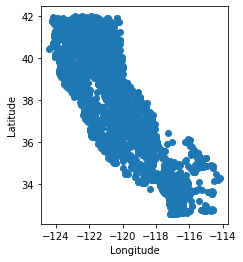

In [57]:
#confirming the geodataframe plots correctly
wildfires_gdf[wildfires_gdf['FIRE_YEAR'] == 2005].plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude');

In [58]:
#load counties shapefile as geodataframe
counties_gdf = gpd.read_file('Datasets/CA_Counties/CA_Counties_TIGER2016.shp')

#check coordinate system of both gdfs (needs to be the same for spatial join to work properly)
counties_crs = counties_gdf.crs
wildfires_crs = wildfires_gdf.crs

print(f'CRS of counties: {counties_crs}')
print(f'CRS of wildfires: {wildfires_crs}')

CRS of counties: epsg:3857
CRS of wildfires: EPSG:4269


In [59]:
counties_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483 4627725.228, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,"MULTIPOLYGON (((-13317853.594 3931602.414, -13..."


In [60]:
# convert CRS of counties to NAD83 
counties_gdf = counties_gdf.to_crs(4269)

#confirm they are now in the same crs
counties_gdf.crs == wildfires_gdf.crs

True

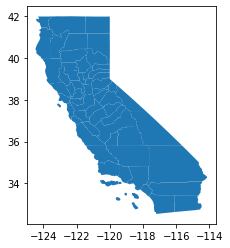

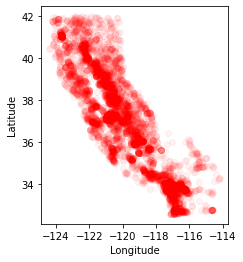

In [61]:
#confirming the geodataframe plots correctly
_ = counties_gdf.plot()
_ = wildfires_gdf[wildfires_gdf['FIRE_YEAR'] == 2005].plot(color='r', alpha=0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [62]:
wildfires_gdf.drop(['index_right'], axis=1, inplace=True)
#counties_gdf.drop(['index_right', 'index_left'], axis=1, inplace=True)

In [63]:
%%time
#spatial join (based on location) of wildfires points to county polygons (only want NAME column)
wildfires_gdf_countyjoin = gpd.tools.sjoin(wildfires_gdf, counties_gdf, how="left")
wildfires_gdf_countyjoin

CPU times: user 19.2 s, sys: 122 ms, total: 19.3 s
Wall time: 19.3 s


,Unnamed: 0,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,H1,G4020,None,None,None,A,6.612401e+09,1.563876e+08,+39.9922953,-120.8243709
8,1,8,FS-1418854,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,H1,G4020,454,39820,None,A,9.778179e+09,1.865302e+08,+40.7605142,-122.0435556
9,2,9,FS-1418856,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,H1,G4020,None,None,None,A,1.626197e+10,1.791083e+08,+41.5879861,-122.5332868
77,3,78,FS-1419054,FED,FS-FIRESTAT,FS,USCASRF,Six Rivers National Forest,0510,Six Rivers National Forest,...,H1,G4020,None,21700,None,A,9.240993e+09,1.254298e+09,+40.7066731,-123.9258181
88,4,89,FS-1419071,FED,FS-FIRESTAT,FS,USCAANF,Angeles National Forest,0501,Angeles National Forest,...,H1,G4020,348,31080,31084,A,1.051065e+10,1.794730e+09,+34.1963983,-118.2618616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880461,83907,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,...,H1,G4020,454,39820,None,A,9.778179e+09,1.865302e+08,+40.7605142,-122.0435556
1880462,83908,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,H1,G4020,382,33700,None,A,3.874643e+09,4.637646e+07,+37.5623162,-121.0028311
1880463,83909,300348375,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,H1,G4020,382,33700,None,A,3.874643e+09,4.637646e+07,+37.5623162,-121.0028311


In [64]:
#dropping unnecessary columns that came from counties shapefile
drop_columns = ['index_right',
       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON']

wildfires_gdf_countyjoin.drop(drop_columns, axis=1, inplace=True)

In [65]:
#rename county name fields
wildfires_gdf_countyjoin=wildfires_gdf_countyjoin.rename(columns = {'NAME':'COUNTY_NAME'})

In [66]:
#drop original county field that had nulls in it
wildfires_gdf_countyjoin.drop(['FIPS_NAME','COUNTY'], axis=1, inplace=True)

In [67]:
#drop records that didn't get a county name (25 records)
wildfires_gdf_countyjoin.dropna(axis=0, subset=['COUNTY_NAME'], inplace=True)

In [72]:
#final export of data
wildfires_gdf_countyjoin.to_csv("Datasets/wildfires_withvars.csv")

In [ ]:
#groupby: county, month, year - sum
large_wildfires = wildfires[wildfires['FIRE_SIZE_CLASS'].isin(['B','C','D','E','F','G'])]
large_wildfire_bymonth = large_wildfires.groupby(by=['FIRE_YEAR','DISCOVERY_MONTH','COUNTY_NAME'],as_index=False).count()
large_wildfire_bymonth = large_wildfire_bymonth[['FIRE_YEAR','DISCOVERY_MONTH','COUNTY_NAME','LATITUDE']]
large_wildfire_bymonth = large_wildfire_bymonth.rename(columns={'LATITUDE':'monthly_large_wf'})

#groupby: county, month - mean
large_wildfire_bymonth = large_wildfire_bymonth.groupby(by=['DISCOVERY_MONTH','COUNTY_NAME'],as_index=False).mean()
large_wildfire_bymonth['monthly_large_wf'] = large_wildfire_bymonth['monthly_large_wf'].round(2)
large_wildfire_bymonth = large_wildfire_bymonth.drop(columns='FIRE_YEAR')
large_wildfire_bymonth[large_wildfire_bymonth['COUNTY_NAME']=='El Dorado']

#join to wildfires dataframe
wildfires = pd.merge(wildfires, large_wildfire_bymonth, on=['DISCOVERY_MONTH','COUNTY_NAME'])